<a href="https://colab.research.google.com/github/Ethel-Ogallo/multitask_regression_deeplearning/blob/master/Multi_task_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-Task Regression Using ResNet50

This notebook demonstrates a **supervised multi-task regression** workflow for remote sensing using **TorchGeo** using the Digital Typhoon dataset, which consists of infrared (IR) satellite imagery of tropical cyclones paired with meteorological measurements.

The objective is to predict multiple continuous typhoon intensity variables from satellite imagery using a deep learning model.  

### Dataset Overview
The [Digital Typhoon](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#digital-typhoon) is derived from hourly infrared channel observations captured by multiple generations of the Himawari meteorological satellites, spanning the period from 1978. The satellite measurements have been converted to brightness temperatures and normalized across different sensors, resulting in a consistent spatio-temporal dataset covering more than four decades.  

**Dataset features:**
- Infrared (IR) satellite imagery of 512 × 512 pixels at ~5km resolution
- Auxiliary metadata including wind speed, pressure and additional typhoon-related attributes  
- 1,099 typhoons and 189,364 images

**References**  
1. Machine Learning for the Digital Typhoon Dataset:
Extensions to Multiple Basins and New Developments
in Representations and Tasks: [arXiv:2411.16421](https://arxiv.org/pdf/2411.16421)  
2. Digital Typhoon: Long-term Satellite Image Dataset
for the Spatio-Temporal Modeling of Tropical Cyclones: [arXiv:2311.02665](https://arxiv.org/pdf/2311.02665)

*notes from paper:*  
*the images feature a 2D array of brightness temperatures around the typhoon’s center, formatted in HDF5*

In [1]:
!pip install torchgeo --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 45.6 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 52.7 MB/s eta 0:00:00


In [ ]:
## import package
import os
import shutil
import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import time

import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import MeanAbsoluteError

from torchvision import transforms
from torchvision import models
from torchvision.transforms import Resize

from torchgeo.datasets import DigitalTyphoon
from torchgeo.datamodules import DigitalTyphoonDataModule
from torchgeo.trainers import RegressionTask
from torchgeo.models import resnet50, ResNet50_Weights

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichProgressBar
from lightning.pytorch.loggers import WandbLogger
import wandb

In [ ]:
# load dataset
root = "/home/ogallo/DL4CV/DigitalTyphoon"

dataset = DigitalTyphoon(
    root=root,
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False
)


In [ ]:
aux_data = pd.read_csv("/home/ogallo/DL4CV/DigitalTyphoon/WP/aux_data.csv")
print(aux_data.head())     # inspect auxiliary data

#### Subset the dataset
This is based on the typhoon event. We choose 1% of the typhoons i.e. 100 and then stratify teh images based on grade and lifecycle??

In [ ]:
# Import the sampling functions
from sample_v2 import load_data, sample_typhoons, sample_images, copy_images, save_sampled_data, copy_metadata

# Set paths and parameters
root = "/home/ogallo/DL4CV/DigitalTyphoon/WP"
output_dir = "/home/ogallo/DL4CV/WP_sampled_10pct"
total_typhoons = 110

# Load data
df = load_data(root)
print(f"Loaded {len(df)} records from {df['id'].nunique()} typhoons.")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")

# Sample typhoons (distributed across years)
sampled_typhoons = sample_typhoons(df, total_typhoons, seed=42)
print(f"\nSelected {len(sampled_typhoons)} typhoons.")

# Sample all images for selected typhoons (no cap)
df_sampled = sample_images(df, sampled_typhoons)
print(f"Sampled {len(df_sampled)} images across {df_sampled['id'].nunique()} typhoons.")

# Copy images
copied, not_found = copy_images(df_sampled, root, output_dir)
print(f"\nCopied {copied}/{len(df_sampled)} images.")
if not_found:
    print(f"Warning: {len(not_found)} images not found.")

# Save sampled data
save_sampled_data(df_sampled, output_dir)
print(f"Saved aux_data.csv")

# Copy metadata
sampled_typhoon_ids = sorted(df_sampled['id'].unique())
copy_metadata(root, output_dir, sampled_typhoon_ids)
print(f"Copied and filtered metadata.")

In [3]:
dataset = DigitalTyphoon(
    root="/kaggle/input/wp-10pct-sample/WP_sampled_10pct",
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False
)

In [ ]:
dataset.__len__
dataset.__getitem__(index=0)

In [ ]:
# sample = dataset.__getitem__(index=0)
# dataset.plot(sample)

In [ ]:
# visualize input
aux_df = pd.read_csv("/kaggle/input/wp-10pct-sample/WP_sampled_10pct/WP/aux_data.csv")
aux_df = aux_df.reset_index(drop=True)

# random indices
indices = np.random.choice(len(dataset), size=4, replace=False)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    sample = dataset[idx]
    image = sample['image'].squeeze()
    wind = sample['wind']
    pressure = sample['pressure']

    row = aux_df.iloc[idx] # Lookup metadata from aux_df
    typhoon_id = row['id']
    grade = row['grade']

    plt.subplot(1, 4, i + 1)
    plt.imshow(image, cmap='viridis')
    plt.title(f"Typhoon:{typhoon_id}, Grade:{grade}, \nWind:{wind:.3f}, Pressure:{pressure:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### ResNet50
understand and explain model architecture with 2 head for multitask regression (add pic/infograph if possible)

in markdown also include what we will do train, val and test then tuning???
 we resize from 512x512 to 224x224 , resnet default + memory issues

**wandb logger?? torchgeo.logger......

### normalize data and resize images

In [ ]:
#set seed
pl.seed_everything(42)

# transform images 
from torchvision import transforms
import torch

def typhoon_transform(sample):
    img = sample["image"]
    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1)
    img = transforms.Resize((224, 224), antialias=True)(img)
    img = transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )(img)
    sample["image"] = img
    return sample

# Pass it directly → applies to train + val + test
datamodule = DigitalTyphoonDataModule(
    split_by='typhoon_id',
    batch_size=16,
    num_workers=4,
    root="/kaggle/input/wp-10pct-sample/WP_sampled_10pct",
    task="regression",
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False,
    transforms=typhoon_transform,   
)

In [ ]:
# Train batch
datamodule.prepare_data()
datamodule.setup(stage="fit")  # creates train/val datasets
batch = next(iter(datamodule.train_dataloader()))
print("Wind:", batch["wind"].min(), batch["wind"].max())
print("Pressure:", batch["pressure"].min(), batch["pressure"].max())
print("Image shape:", batch["image"].shape)       
print("Image dtype:", batch["image"].dtype) 
print("Train samples:", len(datamodule.train_dataset))
print("Val samples:", len(datamodule.val_dataset))


In [4]:
pl.seed_everything(42)

def typhoon_transform(sample, train: bool = True):
    """
    Transform function for DigitalTyphoon dataset.
    
    Args:
        sample: dict with "image" tensor and target features
        train: whether it's training (applies augmentations)
    
    Returns:
        sample: transformed sample
    """
    # ensure tensor type
    img = torch.as_tensor(sample["image"], dtype=torch.float32)

    # If image is HxWxC, permute to CxHxW
    if img.ndim == 3 and img.shape[-1] in [1,3]:
        img = img.permute(2,0,1)
    
    # If single channel, repeat to 3 channels
    if img.shape[0] == 1:
        img = img.repeat(3,1,1)
    
    # Resize to 224x224 for ResNet50
    img = transforms.Resize((224,224), antialias=True)(img)
    
    if train:
        # --- Data augmentation ---
        img = transforms.RandomHorizontalFlip(0.5)(img)
        img = transforms.RandomRotation(10)(img)
        img = img + 0.01 * torch.randn_like(img)  # light noise
    
    # Normalize to ImageNet stats
    img = transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )(img)
    
    sample["image"] = img
    return sample

# instantiate
datamodule = DigitalTyphoonDataModule(
    split_by="typhoon_id",
    batch_size=16,
    num_workers=4,
    root="/kaggle/input/wp-10pct-sample/WP_sampled_10pct",
    task="regression",
    features=["wind","pressure"],
    targets=["wind","pressure"],
    sequence_length=1,
    download=False,
    transforms=lambda sample: typhoon_transform(sample, train=True)  # training transform
)

# apply
datamodule.setup("fit")
datamodule.val_dataset.dataset.transforms = lambda sample: typhoon_transform(sample, train=False)


Seed set to 42


Train base model with deafult parameters  
adapt model to have 2 heads for each target instead of teh classification head

In [5]:
class RegressionTwoHead(pl.LightningModule):
    def __init__(
        self,
        learning_rate: float = 3e-4,
        pretrained: bool = True,
        freeze_backbone: bool = True,
        dropout_rate: float = 0.3,
        head_hidden_size: int = 256,
        loss_weight_wind: float = 1.0,
        loss_weight_pressure: float = 1.0,
    ):
        """
        Two-head ResNet50 for wind speed + central pressure regression.
        - Pretrained ImageNet V2 backbone
        - Deeper heads with BN + Dropout
        - MAE metrics only (most relevant for typhoon intensity)
        - Weighted MSE + scheduler
        """
        super().__init__()
        self.save_hyperparameters()

        # --- Backbone ---
        # weights = ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        weights = ResNet50_Weights.SENTINEL2_RGB_MOCO if pretrained else None
        backbone = resnet50(weights=weights)
        
        if freeze_backbone and pretrained:
            for param in backbone.parameters():
                param.requires_grad = False
        
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.flatten = nn.Flatten()
        feature_size = 2048

        # --- Heads ---
        def make_head():
            return nn.Sequential(
                nn.Linear(feature_size, head_hidden_size),
                nn.BatchNorm1d(head_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(head_hidden_size, 256),
                nn.ReLU(),
                nn.Dropout(dropout_rate * 0.5),
                nn.Linear(256, 1)
            )
        
        self.head_wind = make_head()
        self.head_pressure = make_head()

        # Loss & Metrics 
        self.criterion = nn.MSELoss()
        
        self.train_mae_wind    = MeanAbsoluteError()
        self.train_mae_pressure = MeanAbsoluteError()
        self.val_mae_wind      = MeanAbsoluteError()
        self.val_mae_pressure  = MeanAbsoluteError()

        self.loss_weight_wind    = loss_weight_wind
        self.loss_weight_pressure = loss_weight_pressure

        self.test_mae_wind = MeanAbsoluteError()
        self.test_mae_pressure = MeanAbsoluteError()


    def forward(self, x):
        features = self.backbone(x)
        features = self.flatten(features)
        wind     = self.head_wind(features)
        pressure = self.head_pressure(features)
        return torch.cat([wind, pressure], dim=1)

    def _shared_step(self, batch, stage: str = "train"):
        imgs = batch["image"]
        wind_true  = batch["wind"]
        press_true = batch["pressure"]
        
        preds = self(imgs)  # [B, 2]
        
        # Handle possible extra dimension in targets
        if wind_true.dim() > 1:
            wind_true = wind_true.squeeze(-1)
        if press_true.dim() > 1:
            press_true = press_true.squeeze(-1)
        
        loss_wind    = self.criterion(preds[:, 0], wind_true)
        loss_pressure = self.criterion(preds[:, 1], press_true)
        
        total_loss = (
            self.loss_weight_wind * loss_wind +
            self.loss_weight_pressure * loss_pressure
        )
        
        # Update MAE metrics
        getattr(self, f"{stage}_mae_wind")(preds[:, 0], wind_true)
        getattr(self, f"{stage}_mae_pressure")(preds[:, 1], press_true)

        # Logging
        # self.log_dict({
        #     f"{stage}_loss": total_loss,
        #     f"{stage}_loss_wind": loss_wind,
        #     f"{stage}_loss_pressure": loss_pressure,
        #     f"{stage}_mae_wind": getattr(self, f"{stage}_mae_wind"),
        #     f"{stage}_mae_pressure": getattr(self, f"{stage}_mae_pressure"),
        # }, on_step=(stage == "train"), on_epoch=True, prog_bar=True)

        if stage == "train":
            self.log("train_loss_epoch", total_loss, on_step=False, on_epoch=True)
            self.log("train_loss_wind_epoch", loss_wind, on_step=False, on_epoch=True)
            self.log("train_loss_pressure_epoch", loss_pressure, on_step=False, on_epoch=True)
            self.log("train_mae_wind_epoch", getattr(self, "train_mae_wind"), on_step=False, on_epoch=True)
            self.log("train_mae_pressure_epoch", getattr(self, "train_mae_pressure"), on_step=False, on_epoch=True)
        
        elif stage == "val":
            self.log("val_loss", total_loss, on_step=False, on_epoch=True)
            self.log("val_loss_wind", loss_wind, on_step=False, on_epoch=True)
            self.log("val_loss_pressure", loss_pressure, on_step=False, on_epoch=True)
            self.log("val_mae_wind", getattr(self, "val_mae_wind"), on_step=False, on_epoch=True)
            self.log("val_mae_pressure", getattr(self, "val_mae_pressure"), on_step=False, on_epoch=True)
        
        elif stage == "test":
            self.log("test_loss", total_loss, on_step=False, on_epoch=True)
            self.log("test_loss_wind", loss_wind, on_step=False, on_epoch=True)
            self.log("test_loss_pressure", loss_pressure, on_step=False, on_epoch=True)
            self.log("test_mae_wind", getattr(self, "test_mae_wind"), on_step=False, on_epoch=True)
            self.log("test_mae_pressure", getattr(self, "test_mae_pressure"), on_step=False, on_epoch=True)

        return total_loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, stage="test")

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=1e-5
        )
        
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=3
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

## instantiate model
model = RegressionTwoHead(
    learning_rate=1e-4,
    pretrained=True,
    freeze_backbone=True,
    dropout_rate=0.25,            
    head_hidden_size=256,
    loss_weight_wind=1.0,
    loss_weight_pressure=1.0,
)  


Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_rgb_moco/resolve/efd9723b59a88e9dc1420dc1e96afb25b0630a3c/resnet50_sentinel2_rgb_moco-2b57ba8b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_moco-2b57ba8b.pth


100%|██████████| 90.0M/90.0M [00:12<00:00, 7.73MB/s]


In [6]:
# Set WANDB key from Kaggle secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["WANDB_API_KEY"] = user_secrets.get_secret("WANDB_API_KEY")


def train_model(
    model: pl.LightningModule,
    datamodule: pl.LightningDataModule,
    max_epochs: int = 30,
    patience: int = 6,
    learning_rate: float = 3e-4,
    use_wandb=True, 
    model_name: str = "resnet50_typhoon",
    project_name: str = "DigitalTyphoon",
):
    """
    Train the model with WandB logging, early stopping, checkpointing,
    and learning rate monitoring.
    """

    # Create a descriptive run name
    run_name = (
        f"{model_name}_"
        f"lr{learning_rate:.0e}_"
        f"freeze{model.hparams.freeze_backbone}_"
        f"drop{model.hparams.dropout_rate}_"
        f"epochs{max_epochs}"
    )

    # WandB Logger
    if use_wandb:
        wandb_logger = WandbLogger(
            project=project_name,
            name=run_name,
            log_model="all",       # saves best + last model
            config=model.hparams,
            mode="online"           
        )
    else:
        wandb_logger = None

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=patience,
            mode="min",
            verbose=True,
            min_delta=0.001
        ),
        ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            filename=f"{model_name}-{{epoch:03d}}-{{val_loss:.2f}}-{{val_mae_wind:.1f}}",
            dirpath=f"checkpoints/{model_name}",
            auto_insert_metric_name=False,
        ),
        LearningRateMonitor(logging_interval="epoch")
    ]

    # Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices=1,
        precision="16-mixed",
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=10
    )

    print(f"Starting training run: {run_name}")
    print(f"WandB project: {project_name}")
    print(f"Logging online: {use_wandb}")

    # Train
    start_time = time.time()

    trainer.fit(model, datamodule=datamodule)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Training time: {elapsed/60:.2f} minutes")

    # wandb.finish()

    return trainer

# ---
trainer = train_model(
    model=model,
    datamodule=datamodule,
    max_epochs=30,
    patience=15,
    learning_rate=1e-4,
    model_name="resnet50_typhoon_v4",
    project_name="DigitalTyphoon"
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Starting training run: resnet50_typhoon_v4_lr1e-04_freezeTrue_drop0.25_epochs30
WandB project: DigitalTyphoon
Logging online: True


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: ogalloethel (ogalloethel-university-of-south-brittany) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name               ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ backbone           │ Sequential        │ 23.5 M │ train │     0 │
│ 1  │ flatten            │ Flatten           │      0 │ train │     0 │
│ 2  │ head_wind          │ Sequential        │  591 K │ train │     0 │
│ 3  │ head_pressure      │ Sequential        │  591 K │ train │     0 │
│ 4  │ criterion          │ MSELoss           │      0 │ train │     0 │
│ 5  │ train_mae_wind     │ MeanAbsoluteError │      0 │ train │     0 │
│ 6  │ train_mae_pressure │ MeanAbsoluteError │      0 │ train │     0 │
│ 7  │ val_mae_wind       │ MeanAbsoluteError │      0 │ train │     0 │
│ 8  │ val_mae_pressure   │ MeanAbsoluteError │      0 │ train │     0 │
│ 9  │ test_mae_wind      │ MeanAbsoluteError │      0 │ train │     0 │
│ 10 │ test_mae_pressure  │ MeanAbsoluteError │      0 │ train │     0 │
└────┴────────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 24.7 M                                                                                               
Total estimated model params size (MB): 98                                                                         
Modules in train mode: 242                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 0.828
Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.788
Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.760
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.760. Signaling Trainer to stop.


Training time: 52.04 minutes


In [7]:
# save model baseline
trainer.save_checkpoint("resnet50_typhoon_baseline_v4.ckpt")

# Reload the saved baseline model
# model = RegressionTwoHead.load_from_checkpoint("resnet50_typhoon_baseline.ckpt")

`weights_only` was not set, defaulting to `False`.


In [8]:
# Connect to your run
api = wandb.Api()
run = api.run("ogalloethel-university-of-south-brittany/DigitalTyphoon/g3gfdwbr")  

# Get history as DataFrame
history = run.history(pandas=True)

# Last epoch values
train_loss_last = history["train_loss_epoch"].dropna().iloc[-1]
# val_loss_last   = history["val_loss"].dropna().iloc[-1]
val_loss_best = history["val_loss"].dropna().min()

print(f"Train Loss (MSE): {train_loss_last:.4f}")
print(f"Val Loss   (MSE): {val_loss_best:.4f}")


Train Loss (MSE): 0.3323
Val Loss   (MSE): 0.7595


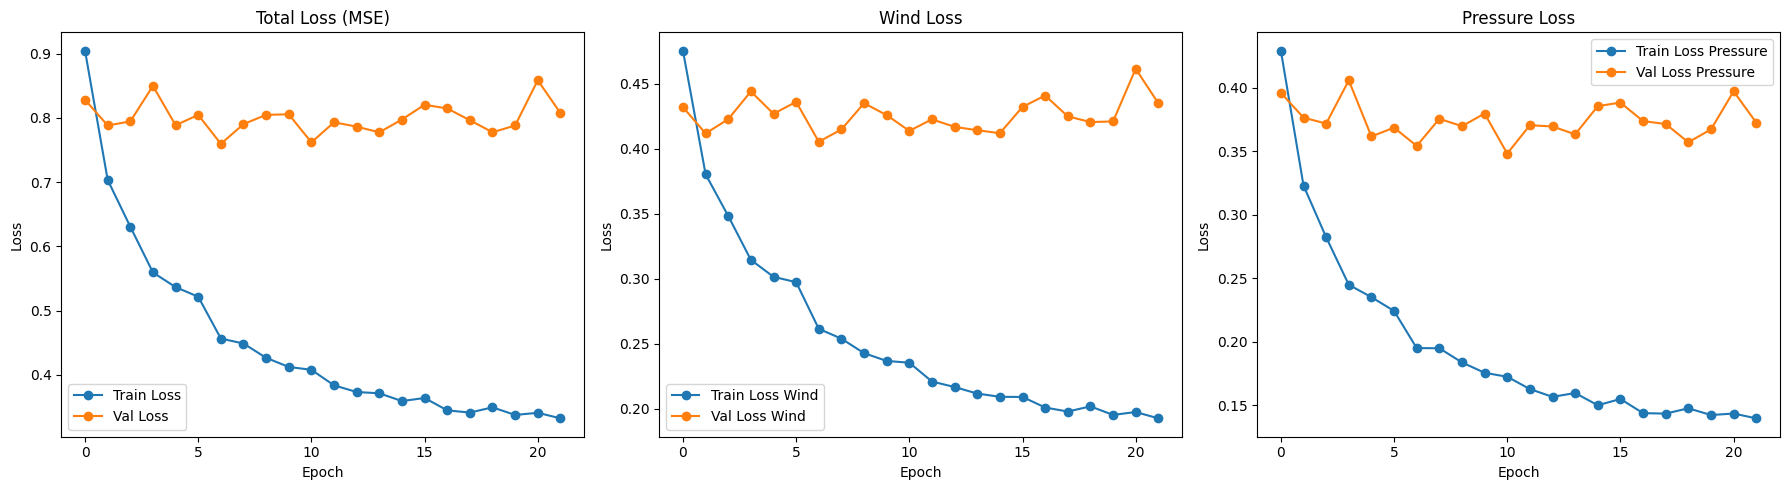

In [11]:
# --- Extract metrics from WandB history ---
train_loss = history["train_loss_epoch"].dropna().tolist()
val_loss   = history["val_loss"].dropna().tolist()
train_loss_wind = history["train_loss_wind_epoch"].dropna().tolist()
val_loss_wind   = history["val_loss_wind"].dropna().tolist()
train_loss_pressure = history["train_loss_pressure_epoch"].dropna().tolist()
val_loss_pressure   = history["val_loss_pressure"].dropna().tolist()

# WIND_STD, PRESS_STD = 19.8, 22.5
# train_mae_wind = (history["train_mae_wind_epoch"].dropna() * WIND_STD).tolist()
# val_mae_wind   = (history["val_mae_wind"].dropna() * WIND_STD).tolist()
# train_mae_pressure = (history["train_mae_pressure_epoch"].dropna() * PRESS_STD).tolist()
# val_mae_pressure   = (history["val_mae_pressure"].dropna() * PRESS_STD).tolist()

fig, axes = plt.subplots(1, 3, figsize=(18,5))

#Total Loss
axes[0].plot(train_loss, "o-", label="Train Loss")  
axes[0].plot(val_loss, "o-", label="Val Loss")          
axes[0].set_title("Total Loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Wind MAE
axes[1].plot(train_loss_wind, "o-", label="Train Loss Wind")
axes[1].plot(val_loss_wind, "o-", label="Val Loss Wind")
axes[1].set_title("Wind Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Pressure MAE
axes[2].plot(train_loss_pressure, "o-", label="Train Loss Pressure")
axes[2].plot(val_loss_pressure, "o-", label="Val Loss Pressure")
axes[2].set_title("Pressure Loss")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()

plt.tight_layout()
plt.show()


### Testing

In [12]:
# --- Load the checkpoint ---
checkpoint_path = "/kaggle/working/resnet50_typhoon_baseline_v4.ckpt"
model = RegressionTwoHead.load_from_checkpoint(checkpoint_path)
model.eval()
model.freeze()  # optional, prevents accidental gradient updates

# --- Prepare datamodule ---
datamodule.setup("test")  # make sure your test dataset is ready
datamodule.test_dataset.dataset.transforms = lambda sample: typhoon_transform(sample, train=False)

# --- Trainer ---
trainer = Trainer(accelerator="auto", devices=1, precision="16-mixed")

# --- Run test ---
test_results = trainer.test(model, datamodule=datamodule, verbose=True)

print("Test results:", test_results)


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
2026-01-25 01:57:30.443161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769306250.607964      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769306250.655222      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769306251.039224      55 computation_placer.cc:177] computation placer already registered. Plea

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7518271803855896     │
│    test_loss_pressure     │    0.32594600319862366    │
│      test_loss_wind       │    0.42588096857070923    │
│     test_mae_pressure     │     0.435730904340744     │
│       test_mae_wind       │    0.5447434186935425     │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_loss': 0.7518271803855896, 'test_loss_wind': 0.42588096857070923, 'test_loss_pressure': 0.32594600319862366, 'test_mae_wind': 0.5447434186935425, 'test_mae_pressure': 0.435730904340744}]


Analysis:  
The baseline model achieved a training loss of 0.1579 and a validation loss of 0.8515.  
This indicates that while the model fits the training data well, it does not generalize as effectively to unseen data, suggesting some degree of overfitting.  
This requires some measures to improve the performance such as: fine-tuning the backbone, adding more regularization.



### hyperparameter tuning using optuna

In [ ]:
# Tuning using optuna


In [ ]:
# train, val metrics plot?